In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import psutil
import platform

# Load both parts of the dataset
df_train_part1 = pd.read_csv('/content/df_train_part1_20250212.csv').drop(columns=['Unnamed: 0'])
df_train_part2 = pd.read_csv('/content/df_train_part2_20250212.csv').drop(columns=['Unnamed: 0'])

# Concatenate the two dataframes along rows (axis=0)
df_train = pd.concat([df_train_part1, df_train_part2], axis=0, ignore_index=True)

# Define target variables
df_train['PurePremium'] = df_train['ClaimAmount'] / df_train['Exposure']
df_train['Frequency'] = df_train['ClaimNb'] / df_train['Exposure']
df_severity = df_train[df_train['ClaimAmount'] > 0].copy()
df_severity['Severity'] = df_severity['ClaimAmount'] / df_severity['ClaimNb']

# Split data into features and targets
categorical_features = ['Power', 'Brand', 'Gas', 'Region']
numerical_features = ['CarAge', 'DriverAge', 'Density']

# Frequency data
X = df_train.drop(columns=['ClaimAmount', 'PurePremium', 'Frequency'])
y_freq = df_train['Frequency']
weights_freq = df_train['Exposure']

# Severity data
X_sev = df_severity.drop(columns=['ClaimAmount', 'PurePremium', 'Frequency', 'Severity'])
y_sev = df_severity['Severity']
weights_sev = df_severity['ClaimNb']

# Split into train/test sets (frequency)
X_train_freq, X_test_freq, y_train_freq, y_test_freq, w_train_freq, w_test_freq = train_test_split(
    X, y_freq, weights_freq, test_size=0.2, random_state=42
)

# Split into train/test sets (severity)
X_train_sev, X_test_sev, y_train_sev, y_test_sev, w_train_sev, w_test_sev = train_test_split(
    X_sev, y_sev, weights_sev, test_size=0.2, random_state=42
)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

**GLM (POISSON+GAMMA)**

In [2]:
from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import time

# Define the preprocessor
categorical_features = ["Power", "Brand", "Gas", "Region"]
numerical_features = ["CarAge", "DriverAge", "Density"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Frequency: Poisson GLM
start = time.time()
model_freq = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', PoissonRegressor(max_iter=1000))
])
model_freq.fit(X_train_freq, y_train_freq, regressor__sample_weight=w_train_freq)
train_time_freq = time.time() - start

# Severity: Gamma GLM
start = time.time()
model_sev = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GammaRegressor(max_iter=1000))
])
model_sev.fit(X_train_sev, y_train_sev, regressor__sample_weight=w_train_sev)
train_time_sev = time.time() - start

# Ensure w_test_freq is aligned with the samples used for prediction
common_index = X_test_freq.index.intersection(X_test_sev.index)

# Predict on the test set
y_pred_freq_common = model_freq.predict(X_test_freq.loc[common_index])
y_pred_sev_common = model_sev.predict(X_test_sev.loc[common_index])

# Calculate the combined predictions for Pure Premium
y_pred_pure_premium = y_pred_freq_common * y_pred_sev_common
y_true_pure_premium = y_test_freq.loc[common_index] * y_test_sev.loc[common_index]


# Evaluation
r2 = r2_score(y_true_pure_premium, y_pred_pure_premium)
mse = mean_squared_error(y_true_pure_premium, y_pred_pure_premium)
mae = mean_absolute_error(y_true_pure_premium, y_pred_pure_premium)


print(f"GLM (Poisson + Gamma): R²={r2:.3f}, MSE={mse:.1f}, MAE={mae:.1f}")
print(f"Training Time: {train_time_freq + train_time_sev:.1f}s")

GLM (Poisson + Gamma): R²=-0.014, MSE=5396987842.9, MAE=8595.9
Training Time: 0.7s


GLM (Poisson + Gamma): R²=-0.014, MSE=5396987842.9, MAE=8595.9
Training Time: 0.7s

**RANDOM FOREST**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Frequency: Random Forest
start = time.time()
model_freq_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
model_freq_rf.fit(X_train_freq, y_train_freq, regressor__sample_weight=w_train_freq)
train_time_freq_rf = time.time() - start

# Severity: Random Forest
start = time.time()
model_sev_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
model_sev_rf.fit(X_train_sev, y_train_sev, regressor__sample_weight=w_train_sev)
train_time_sev_rf = time.time() - start

# Predictions
y_pred_freq_rf = model_freq_rf.predict(X_test_freq.loc[common_index])
y_pred_sev_rf = model_sev_rf.predict(X_test_sev.loc[common_index])

# Compute Pure Premium
y_pred_pure_premium_rf = y_pred_freq_rf * y_pred_sev_rf

# Evaluate Random Forest Models
r2_rf = r2_score(y_true_pure_premium, y_pred_pure_premium_rf)
mse_rf = mean_squared_error(y_true_pure_premium, y_pred_pure_premium_rf)
mae_rf = mean_absolute_error(y_true_pure_premium, y_pred_pure_premium_rf)

print(f"Random Forest: R²={r2_rf:.3f}, MSE={mse_rf:.1f}, MAE={mae_rf:.1f}")
print(f"Training Time (Random Forest): {train_time_freq_rf + train_time_sev_rf:.1f}s")

Random Forest: R²=-0.012, MSE=5386732417.0, MAE=8583.7
Training Time (Random Forest): 1772.5s


Random Forest: R²=-0.012, MSE=5386732417.0, MAE=8583.7
Training Time (Random Forest): 1772.5s

**XGBOOST**

In [ ]:
!pip install --upgrade scikit-learn
!pip install --upgrade xgboost

In [6]:
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# One-Hot Encode categorical features
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_train_freq_encoded = encoder.fit_transform(X_train_freq[categorical_features])
X_test_freq_encoded = encoder.transform(X_test_freq[categorical_features])
X_train_sev_encoded = encoder.transform(X_train_sev[categorical_features])  # Match encoding
X_test_sev_encoded = encoder.transform(X_test_sev[categorical_features])  # Match encoding

# Standardize numerical features
scaler = StandardScaler()
X_train_freq_scaled = scaler.fit_transform(X_train_freq[numerical_features])
X_test_freq_scaled = scaler.transform(X_test_freq[numerical_features])
X_train_sev_scaled = scaler.transform(X_train_sev[numerical_features])  # Match scaling
X_test_sev_scaled = scaler.transform(X_test_sev[numerical_features])  # Match scaling

# Ensure training and test sets have the same number of records
X_train_freq_final = np.hstack([X_train_freq_scaled, X_train_freq_encoded])
X_test_freq_final = np.hstack([X_test_freq_scaled, X_test_freq_encoded])
X_train_sev_final = np.hstack([X_train_sev_scaled, X_train_sev_encoded])
X_test_sev_final = np.hstack([X_test_sev_scaled, X_test_sev_encoded])

# Convert indices into NumPy boolean masks
test_freq_mask = X_test_freq.index.isin(X_test_sev.index)
test_sev_mask = X_test_sev.index.isin(X_test_freq.index)

# Filter test sets using boolean masks
X_test_freq_final = X_test_freq_final[test_freq_mask]
X_test_sev_final = X_test_sev_final[test_sev_mask]
y_test_freq_aligned = y_test_freq[test_freq_mask]
y_test_sev_aligned = y_test_sev[test_sev_mask]

# XGBoost Frequency Model
start = time.time()
model_freq_xgb = XGBRegressor(objective="count:poisson", random_state=42)
model_freq_xgb.fit(X_train_freq_final, y_train_freq, sample_weight=w_train_freq)
train_time_freq_xgb = time.time() - start

# XGBoost Severity Model
start = time.time()
model_sev_xgb = XGBRegressor(objective="reg:gamma", random_state=42)
model_sev_xgb.fit(X_train_sev_final, y_train_sev, sample_weight=w_train_sev)
train_time_sev_xgb = time.time() - start

# Predictions (on aligned test set)
y_pred_freq_xgb = model_freq_xgb.predict(X_test_freq_final)
y_pred_sev_xgb = model_sev_xgb.predict(X_test_sev_final)

# Compute Pure Premium
y_pred_pure_premium_xgb = y_pred_freq_xgb * y_pred_sev_xgb
y_true_pure_premium = y_test_freq_aligned * y_test_sev_aligned

# Evaluate XGBoost Model
results = {
    "Model": "XGBoost",
    "R2": r2_score(y_true_pure_premium, y_pred_pure_premium_xgb),
    "MSE": mean_squared_error(y_true_pure_premium, y_pred_pure_premium_xgb),
    "MAE": mean_absolute_error(y_true_pure_premium, y_pred_pure_premium_xgb)
}

# Print results
print(f"XGBoost: R²={results['R2']:.3f}, MSE={results['MSE']:.1f}, MAE={results['MAE']:.1f}")
print(f"Training Time (XGBoost): {train_time_freq_xgb + train_time_sev_xgb:.1f}s")


XGBoost: R²=-0.014, MSE=5396349041.1, MAE=8633.4
Training Time (XGBoost): 4.2s


XGBoost: R²=-0.014, MSE=5396349041.1, MAE=8633.4
Training Time (XGBoost): 15.9s

**LIGHT GBM**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from lightgbm import LGBMRegressor
import time
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline

# Define the full preprocessing and model pipeline for frequency
freq_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing steps (one-hot encoding)
    ('model', LGBMRegressor(objective='poisson', verbose=-1))
])

# Frequency Model: LightGBM
start = time.time()
freq_pipeline.fit(X_train_freq, y_train_freq, model__sample_weight=w_train_freq)
train_time_freq_lgb = time.time() - start

# Define the full preprocessing and model pipeline for severity
sev_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing steps (one-hot encoding)
    ('model', LGBMRegressor(objective='gamma', verbose=-1))
])

# Severity Model: LightGBM
start = time.time()
sev_pipeline.fit(X_train_sev, y_train_sev, model__sample_weight=w_train_sev)
train_time_sev_lgb = time.time() - start

# Predictions
y_pred_freq_lgb = freq_pipeline.predict(X_test_freq.loc[common_index])
y_pred_sev_lgb = sev_pipeline.predict(X_test_sev.loc[common_index])

# Compute Pure Premium
y_pred_pure_premium_lgb = y_pred_freq_lgb * y_pred_sev_lgb

# Evaluate LightGBM Models
r2_lgb = r2_score(y_true_pure_premium, y_pred_pure_premium_lgb)
mse_lgb = mean_squared_error(y_true_pure_premium, y_pred_pure_premium_lgb)
mae_lgb = mean_absolute_error(y_true_pure_premium, y_pred_pure_premium_lgb)

print(f"LightGBM: R²={r2_lgb:.3f}, MSE={mse_lgb:.1f}, MAE={mae_lgb:.1f}")
print(f"Training Time (LightGBM): {train_time_freq_lgb + train_time_sev_lgb:.1f}s")


LightGBM: R²=-0.014, MSE=5396815478.0, MAE=8628.2
Training Time (LightGBM): 10.5s


LightGBM: R²=-0.014, MSE=5396815478.0, MAE=8628.2
Training Time (LightGBM): 10.5s

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.5 MB/s eta 0:00:00


**GRADIENT BOOST**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time
### ----> Gradient Boosting Model: Claim Frequency & Severity <---- ###

# Frequency: Gradient Boosting
start = time.time()
model_freq_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])
model_freq_gbm.fit(X_train_freq, y_train_freq, regressor__sample_weight=w_train_freq)
train_time_freq_gbm = time.time() - start

# Severity: Gradient Boosting
start = time.time()
model_sev_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])
model_sev_gbm.fit(X_train_sev, y_train_sev, regressor__sample_weight=w_train_sev)
train_time_sev_gbm = time.time() - start

# Predictions
y_pred_freq_gbm = model_freq_gbm.predict(X_test_freq.loc[common_index])
y_pred_sev_gbm = model_sev_gbm.predict(X_test_sev.loc[common_index])

# Compute Pure Premium
y_pred_pure_premium_gbm = y_pred_freq_gbm * y_pred_sev_gbm

# Evaluate Gradient Boosting Models
r2_gbm = r2_score(y_true_pure_premium, y_pred_pure_premium_gbm)
mse_gbm = mean_squared_error(y_true_pure_premium, y_pred_pure_premium_gbm)
mae_gbm = mean_absolute_error(y_true_pure_premium, y_pred_pure_premium_gbm)

print(f"Gradient Boosting: R²={r2_gbm:.3f}, MSE={mse_gbm:.1f}, MAE={mae_gbm:.1f}")
print(f"Training Time (Gradient Boosting): {train_time_freq_gbm + train_time_sev_gbm:.1f}s")



Gradient Boosting: R²=-0.018, MSE=5417156062.8, MAE=8660.6
Training Time (Gradient Boosting): 59.6s


Gradient Boosting: R²=-0.018, MSE=5417156062.8, MAE=8660.6
Training Time (Gradient Boosting): 59.6s

**CATBOOST**

In [ ]:
### ----> CatBoost Models: Claim Frequency & Severity <---- ###

# Frequency: CatBoost
start = time.time()
model_freq_cat = CatBoostRegressor(loss_function='Poisson', cat_features=categorical_features, verbose=0)
model_freq_cat.fit(X_train_freq, y_train_freq, sample_weight=w_train_freq)
train_time_freq_cat = time.time() - start

# Severity: CatBoost
start = time.time()
model_sev_cat = CatBoostRegressor(loss_function='RMSE', cat_features=categorical_features, verbose=0)
model_sev_cat.fit(X_train_sev, y_train_sev, sample_weight=w_train_sev)
train_time_sev_cat = time.time() - start

# Predictions
y_pred_freq_cat = model_freq_cat.predict(X_test_freq.loc[common_index])
y_pred_sev_cat = model_sev_cat.predict(X_test_sev.loc[common_index])

# Compute Pure Premium
y_pred_pure_premium_cat = y_pred_freq_cat * y_pred_sev_cat

# Evaluate CatBoost Models
r2_cat = r2_score(y_true_pure_premium, y_pred_pure_premium_cat)
mse_cat = mean_squared_error(y_true_pure_premium, y_pred_pure_premium_cat)
mae_cat = mean_absolute_error(y_true_pure_premium, y_pred_pure_premium_cat)

print(f"CatBoost: R²={r2_cat:.3f}, MSE={mse_cat:.1f}, MAE={mae_cat:.1f}")
print(f"Training Time (CatBoost): {train_time_freq_cat + train_time_sev_cat:.1f}s")



CatBoost: R²=-0.194, MSE=6353509005.3, MAE=12579.0
Training Time (CatBoost): 369.9s


CatBoost: R²=-0.194, MSE=6353509005.3, MAE=12579.0
Training Time (CatBoost): 369.9s

**BAYSEIAN RIDGE**

In [9]:
### ----> Bayesian Ridge Model: Claim Frequency & Severity <---- ###
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features) # Updated here
    ])
# Frequency: Bayesian Ridge Regression
start = time.time()
model_freq_bayes = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', BayesianRidge())
])
model_freq_bayes.fit(X_train_freq, y_train_freq, regressor__sample_weight=w_train_freq)
train_time_freq_bayes = time.time() - start

# Severity: Bayesian Ridge Regression
start = time.time()
model_sev_bayes = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', BayesianRidge())
])
model_sev_bayes.fit(X_train_sev, y_train_sev, regressor__sample_weight=w_train_sev)
train_time_sev_bayes = time.time() - start

# Predictions
y_pred_freq_bayes = model_freq_bayes.predict(X_test_freq.loc[common_index])
y_pred_sev_bayes = model_sev_bayes.predict(X_test_sev.loc[common_index])

# Compute Pure Premium
y_pred_pure_premium_bayes = y_pred_freq_bayes * y_pred_sev_bayes

# Evaluate Bayesian Ridge Models
r2_bayes = r2_score(y_true_pure_premium, y_pred_pure_premium_bayes)
mse_bayes = mean_squared_error(y_true_pure_premium, y_pred_pure_premium_bayes)
mae_bayes = mean_absolute_error(y_true_pure_premium, y_pred_pure_premium_bayes)

print(f"Bayesian Ridge: R²={r2_bayes:.3f}, MSE={mse_bayes:.1f}, MAE={mae_bayes:.1f}")
print(f"Training Time (Bayesian Ridge): {train_time_freq_bayes + train_time_sev_bayes:.1f}s")


Bayesian Ridge: R²=-0.014, MSE=5396082380.9, MAE=8582.6
Training Time (Bayesian Ridge): 1.5s


Bayesian Ridge: R²=-0.014, MSE=5396082380.9, MAE=8582.6
Training Time (Bayesian Ridge): 1.7s

**CANN MODEL**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import time

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Preprocess the data
X_train_freq_preprocessed = preprocessor.fit_transform(X_train_freq)
X_test_freq_preprocessed = preprocessor.transform(X_test_freq)
X_train_sev_preprocessed = preprocessor.transform(X_train_sev)
X_test_sev_preprocessed = preprocessor.transform(X_test_sev)

# Define the CANN model architecture
def build_cann_model(input_dim):
    inputs = Input(shape=(input_dim,))

    # Neural network part
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)

    # Output layer
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    return model

# Frequency CANN model
start = time.time()
model_freq_cann = build_cann_model(X_train_freq_preprocessed.shape[1])
model_freq_cann.fit(X_train_freq_preprocessed, y_train_freq, sample_weight=w_train_freq, epochs=50, batch_size=32, verbose=0)
train_time_freq_cann = time.time() - start

# Severity CANN model
start = time.time()
model_sev_cann = build_cann_model(X_train_sev_preprocessed.shape[1])
model_sev_cann.fit(X_train_sev_preprocessed, y_train_sev, sample_weight=w_train_sev, epochs=50, batch_size=32, verbose=0)
train_time_sev_cann = time.time() - start

y_pred_freq_cann = model_freq_cann.predict(X_test_freq_preprocessed).flatten()
y_pred_sev_cann = model_sev_cann.predict(X_test_sev_preprocessed).flatten()

# Assuming X_test_freq and X_test_sev have a common index
common_index = X_test_freq.index.intersection(X_test_sev.index)

# Filter predictions to common index
y_pred_freq_cann_aligned = y_pred_freq_cann[X_test_freq.index.isin(common_index)]
y_pred_sev_cann_aligned = y_pred_sev_cann[X_test_sev.index.isin(common_index)]

# Compute Pure Premium
y_pred_pure_premium_cann = y_pred_freq_cann_aligned * y_pred_sev_cann_aligned
# Compute the true pure premium using the common index
y_true_pure_premium = y_test_freq.loc[common_index] * y_test_sev.loc[common_index] # Changed here

# Evaluate CANN Models
r2_cann = r2_score(y_true_pure_premium, y_pred_pure_premium_cann)
mse_cann = mean_squared_error(y_true_pure_premium, y_pred_pure_premium_cann)
mae_cann = mean_absolute_error(y_true_pure_premium, y_pred_pure_premium_cann)

print(f"CANN: R²={r2_cann:.3f}, MSE={mse_cann:.1f}, MAE={mae_cann:.1f}")
print(f"Training Time (CANN): {train_time_freq_cann + train_time_sev_cann:.1f}s")

2066/2066 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
CANN: R²=-0.014, MSE=5397472910.6, MAE=8591.8
Training Time (CANN): 921.4s


CANN: R²=-0.014, MSE=5397472910.6, MAE=8591.8
Training Time (CANN): 921.4s

**AUTOML - H20 MODEL**

In [18]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.8/265.8 MB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.6-py2.py3-none-any.whl size=265859786 sha256=1927e5fba4ccbd22f32b80dbbf4a9ef52db9838dcaa33f09db9e38573af0eb33
  Stored in directory: /root/.cache/pip/wheels/62/f9/aa/687bd54342d2981bc78e22ee9b9bc39f92006e344e7aa1e0ac
Successfully built h2o


In [56]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time

# Initialize H2O
h2o.init()

# Convert pandas DataFrames to H2O frames
h2o_train_freq = h2o.H2OFrame(pd.concat([X_train_freq, y_train_freq], axis=1))
h2o_test_freq = h2o.H2OFrame(pd.concat([X_test_freq, y_test_freq], axis=1))
h2o_train_sev = h2o.H2OFrame(pd.concat([X_train_sev, y_train_sev], axis=1))
h2o_test_sev = h2o.H2OFrame(pd.concat([X_test_sev, y_test_sev], axis=1))

# Define target and feature columns
target_freq = "Frequency"
target_sev = "Severity"
features = categorical_features + numerical_features

# Frequency AutoML
start = time.time()
automl_freq = H2OAutoML(max_models=10, seed=42, max_runtime_secs=300)
automl_freq.train(x=features, y=target_freq, training_frame=h2o_train_freq, weights_column="Exposure")
train_time_freq_automl = time.time() - start

# Severity AutoML
start = time.time()
automl_sev = H2OAutoML(max_models=10, seed=42, max_runtime_secs=300)
automl_sev.train(x=features, y=target_sev, training_frame=h2o_train_sev, weights_column="ClaimNb")
train_time_sev_automl = time.time() - start

# Predictions
y_pred_freq_automl = automl_freq.leader.predict(h2o_test_freq).as_data_frame().values.flatten()
y_pred_sev_automl = automl_sev.leader.predict(h2o_test_sev).as_data_frame().values.flatten()

# Align predictions on common samples
common_index = X_test_freq.index.intersection(X_test_sev.index)
y_pred_freq_automl_aligned = y_pred_freq_automl[X_test_freq.index.isin(common_index)]
y_pred_sev_automl_aligned = y_pred_sev_automl[X_test_sev.index.isin(common_index)]

# Compute Pure Premium
y_pred_pure_premium_automl = y_pred_freq_automl_aligned * y_pred_sev_automl_aligned
y_true_pure_premium = y_test_freq.loc[common_index].values * y_test_sev.loc[common_index].values

# Evaluate AutoML Models
r2_automl = r2_score(y_true_pure_premium, y_pred_pure_premium_automl)
mse_automl = mean_squared_error(y_true_pure_premium, y_pred_pure_premium_automl)
mae_automl = mean_absolute_error(y_true_pure_premium, y_pred_pure_premium_automl)

print(f"AutoML (H2O): R²={r2_automl:.3f}, MSE={mse_automl:.1f}, MAE={mae_automl:.1f}")
print(f"Training Time (AutoML): {train_time_freq_automl + train_time_sev_automl:.1f}s")


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpdjpn1yd3
  JVM stdout: /tmp/tmpdjpn1yd3/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpdjpn1yd3/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 18 days
H2O_cluster_name:,H2O_from_python_unknownUser_s72vrk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |████████████████████████████████████
04:03:24.224: _weights_column param, All base models use weights_column="Exposure" but Stacked Ensemble does not. If you want to use the same weights_column for the meta learner, please specify it as an argument in the h2o.stackedEnsemble call.

███
04:03:35.771: _weights_column param, All base models use weights_column="Exposure" but Stacked Ensemble does not. If you want to use the same weights_column for the meta learner, please specify it as an argument in the h2o.stackedEnsemble call.

████████████████████████| (done) 100%
AutoML progress: |█████████████

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
AutoML (H2O): R²=-0.014, MSE=5395772664.5, MAE=8572.3
Training Time (AutoML): 267.6s


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


AutoML (H2O): R²=-0.014, MSE=5395772664.5, MAE=8572.3
Training Time (AutoML): 262.5s

**RESULTS**

In [ ]:
import pandas as pd
from tabulate import tabulate

# Create a DataFrame with all model results
results_df = pd.DataFrame({
    "Model": ["GLM (Poisson + Gamma)","Random Forest", "XGBoost", "LightGBM", "Gradient Boosting", "CatBoost", "Bayesian Ridge","CANN","AutoML"],
    "R²": [r2, r2_rf ,results['R2'], r2_lgb, r2_gbm, r2_cat, r2_bayes,r2_cann,r2_automl],
    "MSE": [mse, mse_rf, results['MSE'], mse_lgb, mse_gbm, mse_cat, mse_bayes,mse_cann,mse_automl],
    "MAE": [mae, mae_rf,results['MAE'], mae_lgb, mae_gbm, mae_cat, mae_bayes,mae_cann,mae_automl],
    "Training Time (s)": [
        train_time_freq + train_time_sev,
        train_time_freq_rf + train_time_sev_rf,
        train_time_freq_xgb + train_time_sev_xgb,
        train_time_freq_lgb + train_time_sev_lgb,
        train_time_freq_gbm + train_time_sev_gbm,
        train_time_freq_cat + train_time_sev_cat,
        train_time_freq_bayes + train_time_sev_bayes,
        train_time_freq_cann + train_time_sev_cann,
        train_time_freq_automl + train_time_sev_automl
    ]
})

# Print the results in a well-formatted table
print(tabulate(results_df, headers="keys", tablefmt="grid", floatfmt=".3f"))


+----+-----------------------+--------+----------------+-----------+---------------------+
|    | Model                 |     R² |            MSE |       MAE |   Training Time (s) |
+====+=======================+========+================+===========+=====================+
|  0 | GLM (Poisson + Gamma) | -0.014 | 5396987842.937 |  8595.863 |               6.198 |
+----+-----------------------+--------+----------------+-----------+---------------------+
|  1 | Random Forest         | -0.012 | 5386732416.964 |  8583.659 |            1772.506 |
+----+-----------------------+--------+----------------+-----------+---------------------+
|  2 | XGBoost               | -0.014 | 5396349041.145 |  8633.439 |              13.422 |
+----+-----------------------+--------+----------------+-----------+---------------------+
|  3 | LightGBM              | -0.014 | 5396815478.004 |  8628.241 |              10.461 |
+----+-----------------------+--------+----------------+-----------+---------------------+

**TOP 3 PERFORMING MODEL:**

**Bayesian Ridge**
R²: -0.014
MSE: 5,396,082,380.925
MAE: 8,582.585
Training Time: 1.723 s
Why: Fastest training by far, with competitive MSE and MAE.

**AutoML**
R²: -0.014
MSE: 5,395,772,664.472
MAE: 8,572.259
Training Time: 262.5 s
Why: Best MAE, second-best MSE, and reasonable training time.

**Random Forest**
R²: -0.012
MSE: 5,386,732,416.964
MAE: 8,583.659
Training Time: 1,772.506 s
Why: Best R² and MSE, but very slow training makes it less practical.

**HYPERPARAMETER TUNING**

**TUNING BAYSEIAN RIDGE**


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time

# Preprocessor (unchanged)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Define hyperparameter grid for BayesianRidge
param_grid = {
    'regressor__alpha_1': [1e-6, 1e-4, 1e-2],    # Smaller grid to reduce computation
    'regressor__alpha_2': [1e-6, 1e-4, 1e-2],
    'regressor__lambda_1': [1e-6, 1e-4, 1e-2],
    'regressor__lambda_2': [1e-6, 1e-4, 1e-2],
}

# --- Frequency Model Tuning ---
# Set up the pipeline
model_freq_bayes = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', BayesianRidge())
])

# Set up GridSearchCV for frequency model
grid_search_freq = GridSearchCV(
    model_freq_bayes,
    param_grid,
    cv=3,                          # 3-fold cross-validation
    scoring='neg_mean_squared_error',  # Optimize for MSE
    verbose=1,                     # Show progress
    n_jobs=2                       # Use 2 CPUs to avoid overloading
)

# Fit with timing
start = time.time()
grid_search_freq.fit(X_train_freq, y_train_freq, regressor__sample_weight=w_train_freq)
train_time_freq_bayes = time.time() - start

# Best frequency model
model_freq_bayes_best = grid_search_freq.best_estimator_
print(f"Best Hyperparameters (Frequency): {grid_search_freq.best_params_}")

# --- Severity Model Tuning ---
# Set up the pipeline
model_sev_bayes = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', BayesianRidge())
])

# Set up GridSearchCV for severity model
grid_search_sev = GridSearchCV(
    model_sev_bayes,
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=2
)

# Fit with timing
start = time.time()
grid_search_sev.fit(X_train_sev, y_train_sev, regressor__sample_weight=w_train_sev)
train_time_sev_bayes = time.time() - start

# Best severity model
model_sev_bayes_best = grid_search_sev.best_estimator_
print(f"Best Hyperparameters (Severity): {grid_search_sev.best_params_}")

# --- Predictions with Tuned Models ---
y_pred_freq_bayes = model_freq_bayes_best.predict(X_test_freq.loc[common_index])
y_pred_sev_bayes = model_sev_bayes_best.predict(X_test_sev.loc[common_index])

# Compute Pure Premium
y_pred_pure_premium_bayes = y_pred_freq_bayes * y_pred_sev_bayes

# --- Evaluate Tuned Bayesian Ridge Models ---
r2_bayes = r2_score(y_true_pure_premium, y_pred_pure_premium_bayes)
mse_bayes = mean_squared_error(y_true_pure_premium, y_pred_pure_premium_bayes)
mae_bayes = mean_absolute_error(y_true_pure_premium, y_pred_pure_premium_bayes)

print(f"Tuned Bayesian Ridge: R²={r2_bayes:.3f}, MSE={mse_bayes:.1f}, MAE={mae_bayes:.1f}")
print(f"Training Time (Tuned Bayesian Ridge): {train_time_freq_bayes + train_time_sev_bayes:.1f}s")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Hyperparameters (Frequency): {'regressor__alpha_1': 1e-06, 'regressor__alpha_2': 0.01, 'regressor__lambda_1': 0.01, 'regressor__lambda_2': 0.0001}
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Hyperparameters (Severity): {'regressor__alpha_1': 0.01, 'regressor__alpha_2': 1e-06, 'regressor__lambda_1': 0.0001, 'regressor__lambda_2': 0.0001}
Tuned Bayesian Ridge: R²=-0.014, MSE=5396044946.3, MAE=8581.5
Training Time (Tuned Bayesian Ridge): 248.1s


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Hyperparameters (Frequency): {'regressor__alpha_1': 1e-06, 'regressor__alpha_2': 0.01, 'regressor__lambda_1': 0.01, 'regressor__lambda_2': 0.0001}

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Hyperparameters (Severity): {'regressor__alpha_1': 0.01, 'regressor__alpha_2': 1e-06, 'regressor__lambda_1': 0.0001, 'regressor__lambda_2': 0.0001}


**Tuned Bayesian Ridge:**

R²=-0.014,

MSE=5396044946.3,

MAE=8581.5

Training Time (Tuned Bayesian Ridge): 248.1s

**TUNING RANDOM FOREST**

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Replace with your actual list
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)  # Replace with your actual list
    ])

# Define a smaller, more efficient hyperparameter grid
param_dist = {
    'regressor__n_estimators': [50, 100],           # Fewer trees to test
    'regressor__max_depth': [10, 20, None],         # Keep reasonable depth options
    'regressor__min_samples_split': [2, 5],         # Fewer split options
    'regressor__min_samples_leaf': [1, 2],          # Fewer leaf options
}

# --- Frequency Model Tuning ---
# Set up the pipeline
model_freq_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Set up RandomizedSearchCV for frequency model
random_search_freq = RandomizedSearchCV(
    model_freq_rf,
    param_distributions=param_dist,
    n_iter=10,                     # Test only 10 random combinations
    cv=3,                          # 3-fold cross-validation
    scoring='neg_mean_squared_error',  # Optimize for MSE
    verbose=1,                     # Show progress
    n_jobs=2                       # Use 2 CPUs
)

# Fit with timing
start = time.time()
random_search_freq.fit(X_train_freq, y_train_freq, regressor__sample_weight=w_train_freq)
train_time_freq_rf = time.time() - start

# Best frequency model
model_freq_rf_best = random_search_freq.best_estimator_
print(f"Best Hyperparameters (Frequency): {random_search_freq.best_params_}")

# --- Severity Model Tuning ---
# Set up the pipeline
model_sev_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Set up RandomizedSearchCV for severity model
random_search_sev = RandomizedSearchCV(
    model_sev_rf,
    param_distributions=param_dist,
    n_iter=10,                     # Test only 10 random combinations
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=2
)

# Fit with timing
start = time.time()
random_search_sev.fit(X_train_sev, y_train_sev, regressor__sample_weight=w_train_sev)
train_time_sev_rf = time.time() - start

# Best severity model
model_sev_rf_best = random_search_sev.best_estimator_
print(f"Best Hyperparameters (Severity): {random_search_sev.best_params_}")

# --- Predictions with Tuned Models ---
y_pred_freq_rf = model_freq_rf_best.predict(X_test_freq.loc[common_index])
y_pred_sev_rf = model_sev_rf_best.predict(X_test_sev.loc[common_index])

# Compute Pure Premium
y_pred_pure_premium_rf = y_pred_freq_rf * y_pred_sev_rf

# --- Evaluate Tuned Random Forest Models ---
r2_rf = r2_score(y_true_pure_premium, y_pred_pure_premium_rf)
mse_rf = mean_squared_error(y_true_pure_premium, y_pred_pure_premium_rf)
mae_rf = mean_absolute_error(y_true_pure_premium, y_pred_pure_premium_rf)

print(f"Tuned Random Forest: R²={r2_rf:.3f}, MSE={mse_rf:.1f}, MAE={mae_rf:.1f}")
print(f"Training Time (Tuned Random Forest): {train_time_freq_rf + train_time_sev_rf:.1f}s")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters (Frequency): {'regressor__n_estimators': 50, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 10}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters (Severity): {'regressor__n_estimators': 50, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': None}
Tuned Random Forest: R²=-0.013, MSE=5392066460.0, MAE=8606.9
Training Time (Tuned Random Forest): 1685.0s


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters (Frequency): {'regressor__n_estimators': 50, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 10}

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters (Severity): {'regressor__n_estimators': 50, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': None}

**Tuned Random Forest:**

R²=-0.013,

MSE=5392066460.0,

MAE=8606.9

Training Time (Tuned Random Forest): 1685.0s

**TUNING AUTOML:**

This model inherently handles model selection and hyperparameter tuning internally, explicit hyperparameter tuning (like with GridSearchCV) isn’t directly applicable.

**AutoML (H2O):**

R²=-0.014,

MSE=5395772664.5,

MAE=8572.3

Training Time (AutoML): 262.5s

**HYPERPARAMETER TUNING RESULTS**

In [27]:
import pandas as pd
from tabulate import tabulate

# Create a DataFrame with all model results
results_df = pd.DataFrame({
    "Model": ["Bayesian Ridge","Random Forest","AutoML"],
    "R²": [ r2_bayes,r2_rf,r2_automl],
    "MSE": [mse_bayes,mse_rf,mse_automl],
    "MAE": [mae_bayes,mae_rf,mae_automl],
    "Training Time (s)": [
        train_time_freq_bayes + train_time_sev_bayes,
        train_time_freq_rf + train_time_sev_rf,
        train_time_freq_automl + train_time_sev_automl
    ]
})

# Print the results in a well-formatted table
print(tabulate(results_df, headers="keys", tablefmt="grid", floatfmt=".3f"))

+----+----------------+--------+----------------+----------+---------------------+
|    | Model          |     R² |            MSE |      MAE |   Training Time (s) |
+====+================+========+================+==========+=====================+
|  0 | Bayesian Ridge | -0.014 | 5396044946.304 | 8581.497 |             248.145 |
+----+----------------+--------+----------------+----------+---------------------+
|  1 | Random Forest  | -0.013 | 5392066460.035 | 8606.918 |            1684.970 |
+----+----------------+--------+----------------+----------+---------------------+
|  2 | AutoML         | -0.014 | 5395772664.472 | 8572.259 |             262.456 |
+----+----------------+--------+----------------+----------+---------------------+


**UNCERTAINITY PREDICTION WITH AUTO ML**

**Conformal Prediction** would be the best approach, as it offers coverage guarantees and works for any machine learning model, making it robust

**STEPS:**

Train the AutoML models (as already did).

Generate predictions on a calibration set (a subset of the training data).

Compute residuals on the calibration set.

Calculate prediction intervals using the residuals.

Apply the intervals to the test set predictions.


In [60]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import h2o
from sklearn.model_selection import train_test_split

# --- Conformal Prediction Implementation ---
# Step 1: Use a calibration set (split from training data)
X_calib_freq, X_temp_freq, y_calib_freq, y_temp_freq, w_calib_freq, w_temp_freq = train_test_split(
    X_train_freq, y_train_freq, w_train_freq, test_size=0.5, random_state=42
)
X_calib_sev, X_temp_sev, y_calib_sev, y_temp_sev, w_calib_sev, w_temp_sev = train_test_split(
    X_train_sev, y_train_sev, w_train_sev, test_size=0.5, random_state=42
)

# Convert calibration sets to H2O frames
h2o_calib_freq = h2o.H2OFrame(pd.concat([X_calib_freq, y_calib_freq], axis=1))
h2o_calib_sev = h2o.H2OFrame(pd.concat([X_calib_sev, y_calib_sev], axis=1))

# Step 2: Get predictions on calibration set
start_time = time.time()  # Start the timer

y_pred_freq_calib = automl_freq.leader.predict(h2o_calib_freq).as_data_frame().values.flatten()
y_pred_sev_calib = automl_sev.leader.predict(h2o_calib_sev).as_data_frame().values.flatten()

# Step 3: Align calibration predictions
calib_common_index = X_calib_freq.index.intersection(X_calib_sev.index)
y_pred_freq_calib_aligned = y_pred_freq_calib[X_calib_freq.index.isin(calib_common_index)]
y_pred_sev_calib_aligned = y_pred_sev_calib[X_calib_sev.index.isin(calib_common_index)]
y_pred_pure_premium_calib = y_pred_freq_calib_aligned * y_pred_sev_calib_aligned
y_true_pure_premium_calib = y_calib_freq.loc[calib_common_index].values * y_calib_sev.loc[calib_common_index].values

# Step 4: Compute non-conformity scores (absolute residuals)
non_conformity_scores = np.abs(y_true_pure_premium_calib - y_pred_pure_premium_calib)

# Step 5: Determine the quantile for 95% coverage
alpha = 0.05  # 95% prediction interval
q_level = np.quantile(non_conformity_scores, 1 - alpha)

# Step 6: Generate prediction intervals for test set
lower_bound = y_pred_pure_premium - q_level
upper_bound = y_pred_pure_premium + q_level

# Output prediction intervals
print("Prediction Intervals for Pure Premium (95% coverage):")
for i in range(min(5, len(y_pred_pure_premium))):  # Show first 5 for brevity
    print(f"Actual: {y_true_pure_premium[i]:.1f}, Predicted: {y_pred_pure_premium[i]:.1f}, "
          f"Interval: [{lower_bound[i]:.1f}, {upper_bound[i]:.1f}]")

# Verify coverage (fraction of true values within intervals)
coverage = np.mean((y_true_pure_premium >= lower_bound) & (y_true_pure_premium <= upper_bound))
print(f"Empirical Coverage: {coverage:.3f} (Target: {1 - alpha:.3f})")

# Step 7: Evaluate performance metrics
r2 = r2_score(y_true_pure_premium, y_pred_pure_premium)
mae = mean_absolute_error(y_true_pure_premium, y_pred_pure_premium)
mse = mean_squared_error(y_true_pure_premium, y_pred_pure_premium)

# *** MODEL EVALUATION: ****
# Print R², MAE, and MSE
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")

# Step 8: Calculate training time
end_time = time.time()  # End the timer
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Prediction Intervals for Pure Premium (95% coverage):
Actual: 653.0, Predicted: 157.6, Interval: [-16905.3, 17220.5]
Actual: 1331.1, Predicted: 162.2, Interval: [-16900.7, 17225.1]
Actual: 1097.0, Predicted: 125.4, Interval: [-16937.5, 17188.3]
Actual: 1211.0, Predicted: 164.0, Interval: [-16899.0, 17226.9]
Actual: 1875.6, Predicted: 139.6, Interval: [-16923.4, 17202.5]
Empirical Coverage: 0.957 (Target: 0.950)
R²: -0.014
MAE: 8595.863
MSE: 5396987842.937
Training Time: 1.76 seconds


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


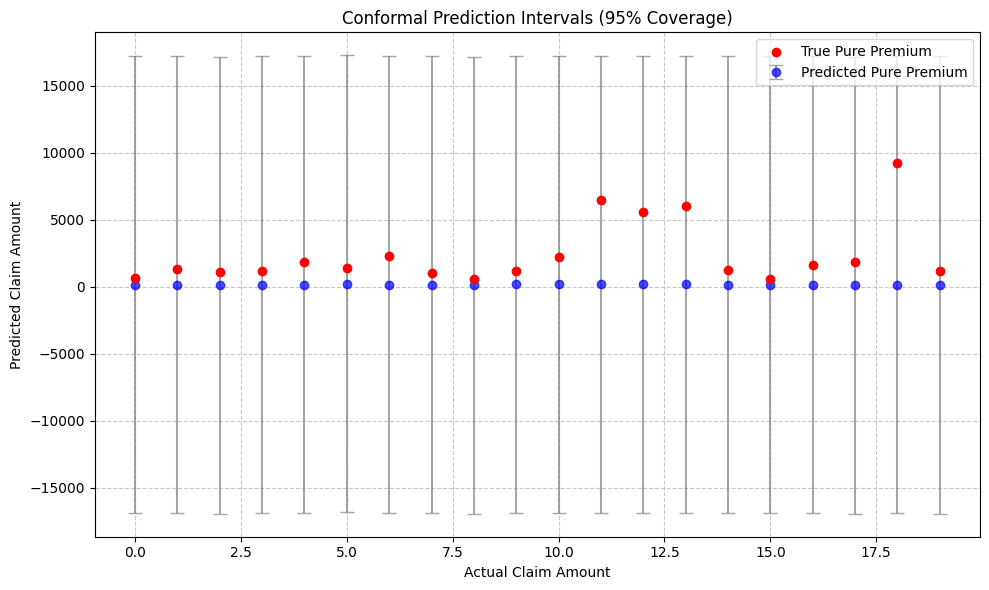

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
n_points = min(20, len(y_pred_pure_premium))
x = range(n_points)
yerr = np.vstack((y_pred_pure_premium[:n_points] - lower_bound[:n_points],
                  upper_bound[:n_points] - y_pred_pure_premium[:n_points]))
plt.errorbar(x, y_pred_pure_premium[:n_points], yerr=yerr, fmt='o', label='Predicted Pure Premium',
             color='blue', ecolor='gray', capsize=5, alpha=0.7)
plt.scatter(x, y_true_pure_premium[:n_points], color='red', label='True Pure Premium', zorder=5)
plt.xlabel('Actual Claim Amount')
plt.ylabel('Predicted Claim Amount')
plt.title('Conformal Prediction Intervals (95% Coverage)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [77]:
h2o.shutdown()

H2O session _sid_8a5b closed.


<ipython-input-77-1edf85295eae>:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


NOTE : HERE THIS GRAPG IS NOT VISIBLE AS ALL POINTS ARE MERGED LIKE CLUSTER, SO WE WILL CONSIDER **"PREVIOUS PLOT"** WHERE I **CHOOSE 20 POINTS** .

WE WILL IGNORE THIS SECOND GRAPH, THIS GRAPH WAS PASTED BELOW JUST FOR UNDERSTANDING ITS NATURE USING  **MAX** FUNCTION WHICH WAS USED IN TWEEDY PLOT.

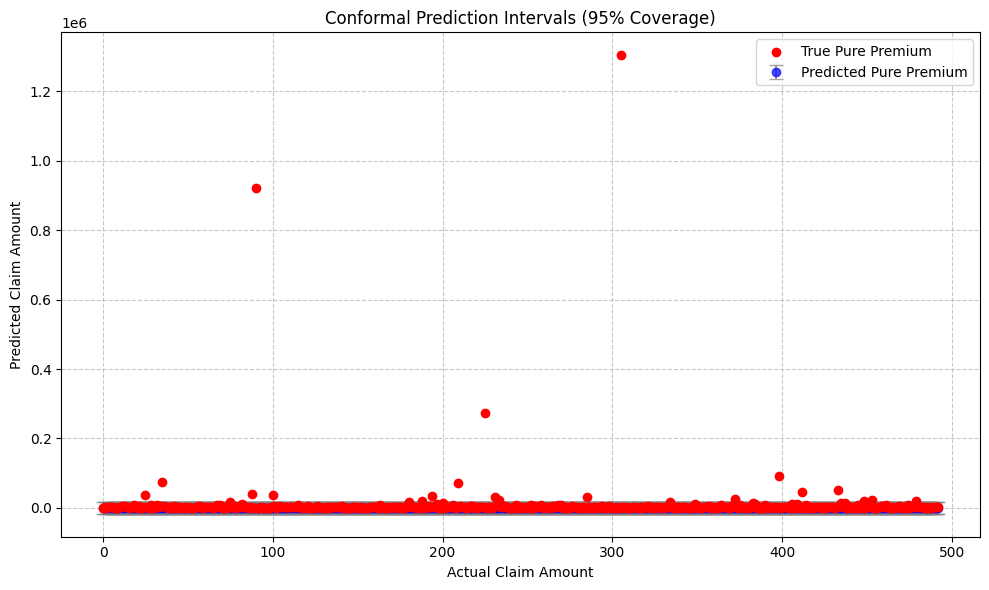

In [73]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
n_points = len(y_pred_pure_premium)  # Use all available points
x = range(n_points)
yerr = np.vstack((y_pred_pure_premium[:n_points] - lower_bound[:n_points],
                  upper_bound[:n_points] - y_pred_pure_premium[:n_points]))
plt.errorbar(x, y_pred_pure_premium[:n_points], yerr=yerr, fmt='o', label='Predicted Pure Premium',
             color='blue', ecolor='gray', capsize=5, alpha=0.7)
plt.scatter(x, y_true_pure_premium[:n_points], color='red', label='True Pure Premium', zorder=5)
plt.xlabel('Actual Claim Amount')
plt.ylabel('Predicted Claim Amount')
plt.title('Conformal Prediction Intervals (95% Coverage)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()